In [142]:
# %matplotlib inline
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier, plot_tree
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, log_loss, precision_score
# from pandas import DataFrame, concat
# from numpy.random import seed
# from sklearn.feature_selection import SelectKBest, chi2, f_classif
# from sklearn.decomposition import PCA
# from catboost import CatBoostRegressor
# from catboost import Pool
# from graphviz import Source
# from sklearn.tree import export_graphviz
# from sklearn.preprocessing import PolynomialFeatures
# import shap
# import datetime
# import matplotlib.pyplot as plt
# from numpy import max
# from pandasql import sqldf
# from sklearn.metrics import roc_curve
# import numpy as np
# import pandas as pd
# experiment_model = CatBoostRegressor()
# df = pd.read_csv("../data/interim/train.csv") # .drop_duplicates()
# df = pd.concat([df.loc[df['is_paired'] == 0], df.loc[df['is_paired'] == 1].head(int(df.loc[df['is_paired'] == 0].shape[0]*.2048))], axis='index')

# # df = pd.read_csv("../data/raw/1.csv")
# df.shape


(1397399, 18)

In [163]:
df['position'].value_counts()

Villain BN RFI and You BB Call       117063
Villain HJ RFI and You BB Call       116762
HJ RFI                               116645
Villain LJ RFI and You BB Call       116583
CO RFI and You BB Call               116570
CO RFI                               116538
BN RFI                               116466
Villain RFI and You Call (Not BB)    116241
SB RFI                               116190
Villain SB RFI and You BB Call       116187
LJ RFI                               116179
You RFI, get 3Bet and you Call       115975
Name: position, dtype: int64

In [144]:
seed(42)
temp_df = df.copy()
# temp_df = temp_df[["bluff_code", "target"]]
# temp_df = df.sample(100000)
# temp_df = df[df["position"] == "BN RFI"]
# X = temp_df.drop(["target", "position"], axis=1)
X = temp_df.drop(["cat4_flop_bluff_second", "cat4_turn_bluff_second", "cat4_river_bluff_second"], axis=1)
y = temp_df[["cat4_flop_bluff_second"]]


# X = X[important_columns]
cat_features = [0]

# Get shap dataframes
X = DataFrame(X, columns=X.columns)

# Fit the model on the training set
experiment_model.fit(X, y, cat_features=cat_features, logging_level='Silent')

feature_score = pd.DataFrame(list(zip(X.dtypes.index, experiment_model.get_feature_importance(Pool(X, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()


In [ ]:
pred_y = experiment_model.predict(X)
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(pred_y, y))
print("goodness of fit score", score)
score = np.sqrt(mean_squared_error([y.mean()]*y.shape[0], y))
print("baseline", score)

## The Important Part

In [ ]:
temp_df = df.copy()
temp_df['is_paired'].value_counts(normalize=True)
temp_df.shape

score: 10.573427238643683
score: 8.982771678492792
score: 8.386365890810954
score: 7.8978501814068895
score: 7.8978501814068895
score: 7.8978501814068895
final score: 7.8978501814068895
baseline score: 13.465439336102062


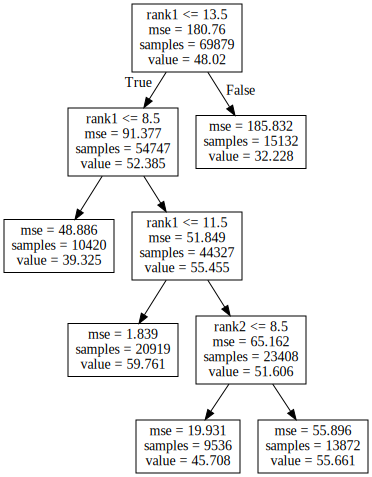

In [158]:
# Get important columns
# importance_threshold = 9
# important_columns = []
# for i, x in zip((feature_score['Score'].round(2) > importance_threshold).index, (feature_score['Score'].round(2) > importance_threshold)):
#     if x:
#         important_columns.append(X.columns[i])
# print("important_columns:", important_columns)

temp_df = df.copy()

temp_df_new = temp_df[temp_df["position"] == "BN RFI"].drop(["position", "range", "top_range"], axis=1) # [["rank1", "my_position_ip", "target"]]
# temp_df_new = temp_df_new.drop(["position"], axis=1)

train, test = train_test_split(temp_df_new, test_size=0.40)

choices = ["cat4_flop_bluff_second", "cat4_turn_bluff_second", "cat4_river_bluff_second"]
target = choices[0]

train_X = train.drop(["cat4_flop_bluff_second", "cat4_turn_bluff_second", "cat4_river_bluff_second"], axis=1)
train_y = train[[target]]
test_X = test.drop(["cat4_flop_bluff_second", "cat4_turn_bluff_second", "cat4_river_bluff_second"], axis=1)
test_y = test[[target]]
min_samples_split = int(train_X.shape[0]*0.3)


from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree, linear_model
%matplotlib inline
for i in range(1,7):
    clf2 = tree.DecisionTreeRegressor(max_depth=i, min_samples_split=min_samples_split)
    clf2.fit(train_X, train_y)
    pred_y = clf2.predict(test_X)
    from sklearn.metrics import mean_squared_error
    score = np.sqrt(mean_squared_error(pred_y, test_y))
    print("score:", score)
    # clf2.coef_

CHOICE = 4

clf2 = tree.DecisionTreeRegressor(max_depth=CHOICE, min_samples_split=min_samples_split)
clf2.fit(train_X, train_y)
pred_y = clf2.predict(test_X)
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(pred_y, test_y))
print("final score:", score)
score = np.sqrt(mean_squared_error([train_y.mean()]*test_y.shape[0], test_y))
print("baseline score:", score)
dot_data = export_graphviz(clf2, out_file=None, feature_names=train_X.columns)
graph = Source(dot_data)
graph.render("graph")        
graph
# clf2.coef_    


In [160]:
choice = temp_df_new.loc[temp_df_new['rank1'].isin([2,3,4,5,6,7,8,14])]
print(choice['cat4_flop_bluff_second'].mean(), choice.shape[0] / temp_df_new.shape[0])
choice = temp_df_new.loc[~temp_df_new['rank1'].isin([2,3,4,5,6,7,8,14])]
print(choice['cat4_flop_bluff_second'].mean(), choice.shape[0] / temp_df_new.shape[0])

35.118202921659204 0.36617553620799204
55.456630406805836 0.633824463792008


In [161]:
def score_button_rfi(rank1):
    if rank1 in [2,3,4,5,6,7,8,14]:
        return 35
    else:
        return 55
pred_y = test_X[['rank1']].apply(lambda x: score_button_rfi(*x), axis=1).astype(float)
pred_y
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(pred_y, test_y))
print("final score:", score)

final score: 9.234774796025254


In [154]:
choice = temp_df_new.loc[((temp_df_new['rank3'] >= 9) | (temp_df_new['rank1'].isin([9,10])))]
print(choice['cat4_flop_bluff_second'].mean(), choice.shape[0] / temp_df_new.shape[0])
choice = temp_df_new.loc[~((temp_df_new['rank3'] >= 9) | (temp_df_new['rank1'].isin([9,10])))]
print(choice['cat4_flop_bluff_second'].mean(), choice.shape[0] / temp_df_new.shape[0])



45.397929957036844 0.2644289525776745
23.727540776449114 0.7355710474223255


In [157]:
def score_sb_rfi(rank1, rank3):
    if rank3 >= 9 or rank1 in [9,10]:
        return 45
    else:
        return 24
pred_y = test_X[['rank1','rank3']].apply(lambda x: score_button_rfi(*x), axis=1).astype(float)
pred_y
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(pred_y, test_y))
print("final score:", score)

final score: 9.70722990452545


In [141]:
choice = temp_df_new.loc[temp_df_new['rank1'].isin([2,3,4,5,6,7,8,14])]
print(choice['cat4_flop_bluff_second'].mean(), choice.shape[0] / temp_df_new.shape[0])

choice = temp_df_new.loc[temp_df_new['rank1'] <= 10]
print(choice['cat4_flop_bluff_second'].mean(), choice.shape[0] / temp_df_new.shape[0])
temp_df_new.loc[~(temp_df_new['rank1'] <= 10)]['cat4_flop_bluff_second'].mean()



32.52421652421653 0.3342857142857143


24.51502145922747

                                           Plots for rank1                                            
                                           Train data plots                                           



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


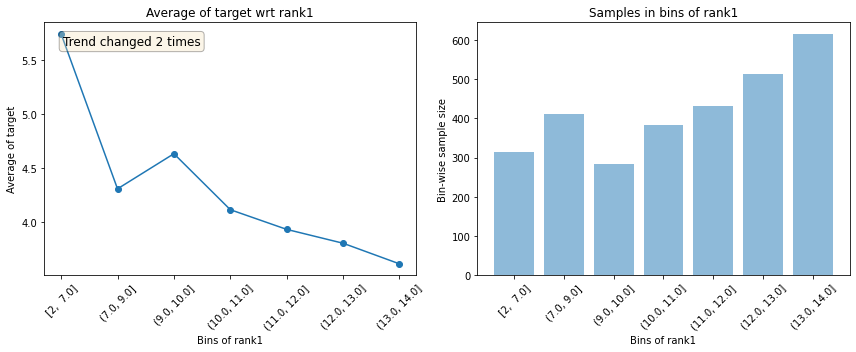

                                           Test data plots                                            


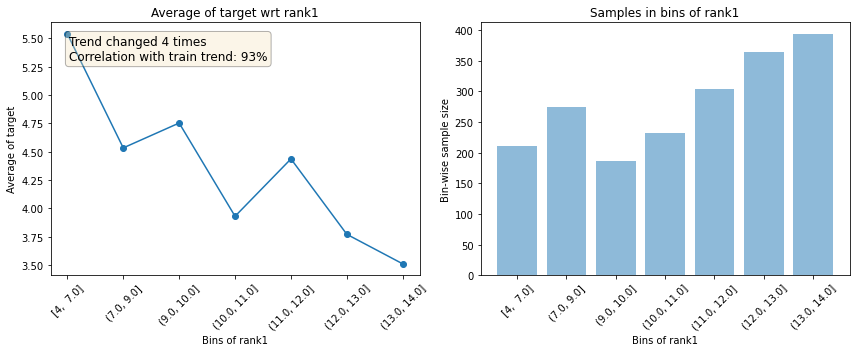

--------------------------------------------------------------------------------------------------------------




In [30]:
from featexp import get_univariate_plots

get_univariate_plots(data=train, target_col='target', data_test=test, features_list=['rank1'])



In [16]:
temp_df['position'].value_counts()

Villain SB RFI and You BB Call       1714
Villain BN RFI and You BB Call       1699
SB RFI                               1691
BN RFI                               1685
HJ RFI                               1664
CO RFI and You BB Call               1664
You RFI, get 3Bet and you Call       1653
LJ RFI                               1639
Villain RFI and You Call (Not BB)    1633
Villain HJ RFI and You BB Call       1632
Villain LJ RFI and You BB Call       1631
CO RFI                               1625
Name: position, dtype: int64

In [ ]:
temp_df_new = temp_df[temp_df["position"] == "LJ RFI"].drop(["position"], axis=1) # [["rank1", "my_position_ip", "target"]]
X_new = temp_df_new.drop(["target"], axis=1)
y = temp_df_new[["target"]]

ys = []
for index, row in test_X.iterrows():
    ys.append(18)
#     if row['rank1'] <= 10 or row['is_paired']:
#         ys.append(17)
#     elif row['rank2'] <= 8:
#         ys.append(18)
#     else:
#         ys.append(19)
        
score = np.sqrt(mean_squared_error(ys, test_y))
print("score:", score)


In [ ]:
# HJ RFI
ys = []
for index, row in X_new.iterrows():
    if row['rank1'] <= 10 and rank2 <= :
        if row['rank2'] <= 8:
            ys.append(18)
        else:
            ys.append(19)
    else:
        ys.append(17)
score = np.sqrt(mean_squared_error(ys, y))
print("score:", score)


Full rules:
- Call:
    - IP:
        - A-K board: 15   (1%)
        - else: 17    (1%)
    - OOP:
        - A-Q board: 8    (13%)
        - else: 10     (11%)
- PFR:
    - IP:
        - CO/BN: 17     (14%)
        - else: 3        (6%)
    - OOP:
        - CO_BN_SB: 8     (7%)        
        - else: 17      (46%)
           
                                
## Simple rules:

- Called: 10
- Late IP: 17
- Other IP: 3
- Late OOP: 8
- Else: 17




In [115]:
for i, name in zip(range(len(X_new.columns)), X_new.columns):
    print(i, name)




0 is_bb
1 is_capped
2 is_paired
3 my_pfr
4 my_position_ip
5 range
6 rank1
7 rank2
8 rank3
9 tones
10 top_range
11 wide_rfi
12 you_3b
13 you_rfi_and_no_raise


In [ ]:
# from sklearn.tree import _tree

# def tree_to_code(tree, train_X):
#     lookup = {}
#     unique, value = np.unique(clf2.apply(train_X), return_counts=True)
#     for (x, y) in zip(unique, value):
#         lookup[x] = y
    
#     feature_names = train_X.columns
    
#     tree_ = tree.tree_
#     feature_name = [
#         feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
#         for i in tree_.feature
#     ]
#     print("def tree({}):".format(", ".join(feature_names)))

#     def recurse(node, depth):
#         indent = "  " * depth
#         if tree_.feature[node] != _tree.TREE_UNDEFINED:
#             name = feature_name[node]
#             threshold = tree_.threshold[node]
#             print("{}if {} <= {}:".format(indent, name, threshold))
#             recurse(tree_.children_left[node], depth + 1)
#             print("{}else:  # if {} > {}".format(indent, name, threshold))
#             recurse(tree_.children_right[node], depth + 1)
#         else:
#             print("{}return {}".format(indent, tree_.value[node]))

#     recurse(0, 1)
    
# tree_to_code(clf2, train_X)  
    
# def extract_from_tree_size_1(dot_data, total_samples):
#     significant_size = total_samples*0.1
#     rule1 = remove_everything(dot_data.split(";")[1].split("\\n")[0])
#     samples1 = int(remove_everything(dot_data.split(";")[1].split("\\n")[2]))
#     value1 = round(float(remove_everything(dot_data.split(";")[1].split("\\n")[3])))
#     print(rule1, samples1, value1)

#     samples2 = int(remove_everything(dot_data.split(";")[2].split("\\n")[1]))
#     value2 = round(float(remove_everything(dot_data.split(";")[2].split("\\n")[2])))
#     if samples2 >= significant_size:
#         print(samples2, value2)

#     samples3 = int(remove_everything(dot_data.split(";")[4].split("\\n")[1]))
#     value3 = round(float(remove_everything(dot_data.split(";")[4].split("\\n")[2])))
#     if samples3 >= significant_size:
#         print(samples3, value3)
        
#     if samples2 >= significant_size:
        
    
